Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')
#root_path = 'drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/'  #change dir to your project folder


Mounted at /content/gdrive/


In [6]:
!unzip gdrive/MyDrive/Skin-Cancer-Upgrad-CaseStudy/CNN_assignment.zip

Archive:  gdrive/MyDrive/Skin-Cancer-Upgrad-CaseStudy/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_00247

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [11]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [12]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [13]:
batch_size = 32
img_height = 180
img_width = 180
IMG_SIZE = (img_height, img_width)

Use 80% of the images for training, and 20% for validation.

In [14]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

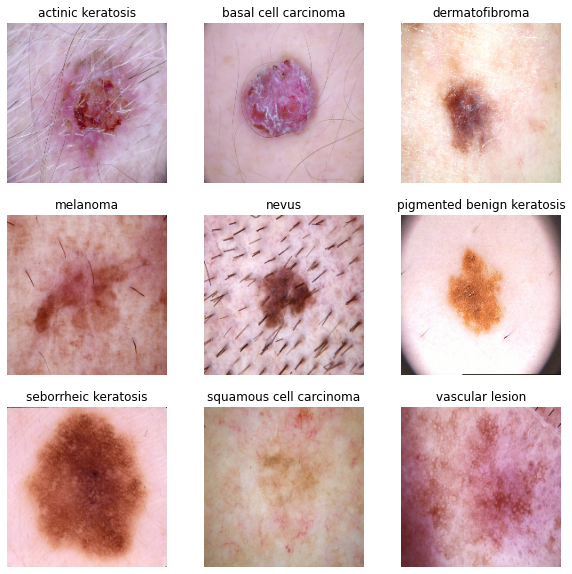

In [17]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

# create a figure with subplots for each class
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

# iterate over the classes
for i, class_name in enumerate(class_names):
    # get one example image of the current class
    for image, label in train_ds.take(1):
        for j in range(image.shape[0]):
            if class_name == label[j].numpy():
                break
    # plot the image in the corresponding subplot
    axes[i].imshow(image[j]/255)
    axes[i].set_title(class_name)
    axes[i].axis('off')

# display the figure
plt.show()

In [18]:
img_shape = train_ds.element_spec[0].shape
print("Image shape:", img_shape)


Image shape: (None, 180, 180, 3)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [20]:
# Create a rescaling layer
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1/255., offset=-1)

# Apply the rescaling layer to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

In [21]:
### Applying scaling on the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

test_ds = test_ds.map(lambda x, y: (rescale(x), y))

Found 118 files belonging to 9 classes.


In [22]:
###using tf.one_hot() function to convert it to one-hot encoded format.
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=9)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=9)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=9)))

In [23]:
###Creating the model

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(9, activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [24]:
### selecting an appropirate optimiser and loss function
###Optimzer = Adam and Loss = CategoricalCrossEntropy
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [25]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0

### Train the model

In [27]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 92ms/step - loss: 1.8406 - accuracy: 0.3164 - val_loss: 1.7932 - val_accuracy: 0.3602
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.5584 - accuracy: 0.4381 - val_loss: 1.5174 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.4516 - accuracy: 0.4883 - val_loss: 1.5256 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 1.3530 - accuracy: 0.5307 - val_loss: 1.3709 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 2s 42ms/step - loss: 1.2610 - accuracy: 0.5402 - val_loss: 1.4096 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 1.1945 - accuracy: 0.5720 - val_loss: 1.3631 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 3s 45ms/step - loss: 1.1491 - accuracy: 0.6016 - val_loss: 1.3910 - val_accuracy: 0.5481
Epoch 8/20
56

### Visualizing training results

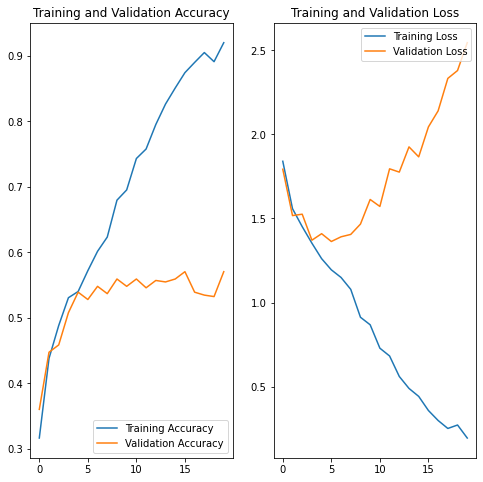

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

##The above model gives an acurracy of 92% and val_accuracy of 57%
##It clearly shows evidence of **overfitting**

##Augmentation Strategy:
RandomFlip("horizontal_and_vertical")
RandomRotation(0.2)

In [29]:
### after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
### Setting Up the data again for augmentation

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)


## Applying Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

##train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
aug_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

merged_ds = train_ds.concatenate(aug_train_ds)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


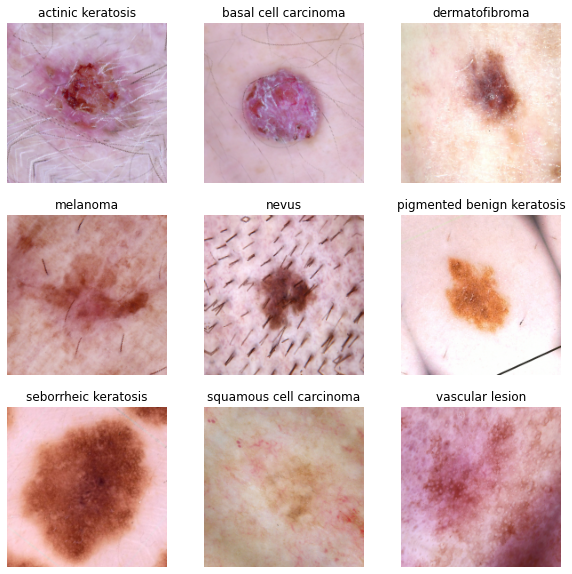

In [30]:
# Todo,  visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
### your code goes here, you can use training or validation data to visualize

# create a figure with subplots for each class
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

# iterate over the classes
for i, class_name in enumerate(class_names):
    # get one example image of the current class
    for image, label in aug_train_ds.take(1):
        for j in range(image.shape[0]):
            if class_name == label[j].numpy():
                break
    # plot the image in the corresponding subplot
    axes[i].imshow(image[j]/255)
    axes[i].set_title(class_name)
    axes[i].axis('off')

# display the figure
plt.show()




In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
merged_ds = merged_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create a rescaling layer
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1/255., offset=-1)

# Apply the rescaling layer to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
merged_ds = merged_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=9)))
merged_ds = merged_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=9)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=9)))

In [32]:
# Define data augmentation techniques
epochs = 20
history = model.fit(
  merged_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
112/112 [==============================] - 30s 61ms/step - loss: 0.9744 - accuracy: 0.6881 - val_loss: 1.4947 - val_accuracy: 0.5503
Epoch 2/20
112/112 [==============================] - 4s 40ms/step - loss: 0.6813 - accuracy: 0.7600 - val_loss: 1.6634 - val_accuracy: 0.5436
Epoch 3/20
112/112 [==============================] - 4s 40ms/step - loss: 0.4996 - accuracy: 0.8220 - val_loss: 2.0513 - val_accuracy: 0.4877
Epoch 4/20
112/112 [==============================] - 4s 40ms/step - loss: 0.3848 - accuracy: 0.8602 - val_loss: 2.2411 - val_accuracy: 0.5391
Epoch 5/20
112/112 [==============================] - 4s 40ms/step - loss: 0.2720 - accuracy: 0.8912 - val_loss: 2.3741 - val_accuracy: 0.5347
Epoch 6/20
112/112 [==============================] - 4s 39ms/step - loss: 0.2002 - accuracy: 0.9244 - val_loss: 2.8253 - val_accuracy: 0.5615
Epoch 7/20
112/112 [==============================] - 5s 42ms/step - loss: 0.1976 - accuracy: 0.9205 - val_loss: 2.9531 - val_accuracy: 0.528

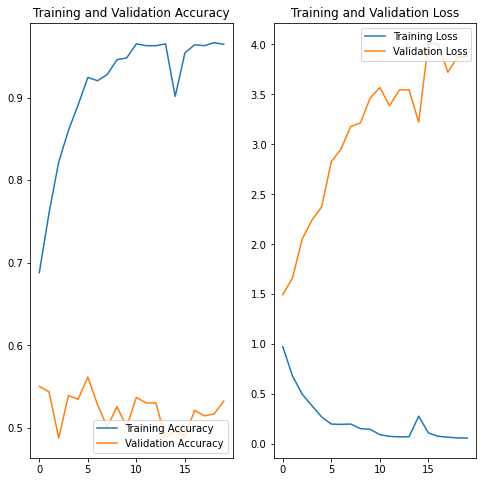

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##The above model gives an acurracy of 97% and val_accuracy of 53%
##It clearly shows evidence of **overfitting**
##Lets apply drop out and check the accuracy and val_accuracy

### Todo:
### Create the model, compile and train the model


In [34]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(9, activation='softmax'))


### Compiling the model

In [35]:
## Your code goes here
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [36]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  merged_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
112/112 [==============================] - 5s 44ms/step - loss: 1.8168 - accuracy: 0.3287 - val_loss: 1.6003 - val_accuracy: 0.4273
Epoch 2/20
112/112 [==============================] - 5s 43ms/step - loss: 1.4999 - accuracy: 0.4498 - val_loss: 1.4994 - val_accuracy: 0.4698
Epoch 3/20
112/112 [==============================] - 5s 43ms/step - loss: 1.3976 - accuracy: 0.5084 - val_loss: 1.4724 - val_accuracy: 0.4676
Epoch 4/20
112/112 [==============================] - 5s 43ms/step - loss: 1.3312 - accuracy: 0.5299 - val_loss: 1.4428 - val_accuracy: 0.4855
Epoch 5/20
112/112 [==============================] - 5s 43ms/step - loss: 1.2725 - accuracy: 0.5463 - val_loss: 1.3716 - val_accuracy: 0.5056
Epoch 6/20
112/112 [==============================] - 5s 43ms/step - loss: 1.2181 - accuracy: 0.5675 - val_loss: 1.4192 - val_accuracy: 0.4989
Epoch 7/20
112/112 [==============================] - 5s 44ms/step - loss: 1.1692 - accuracy: 0.5851 - val_loss: 1.3578 - val_accuracy: 0.5436

### Visualizing the results

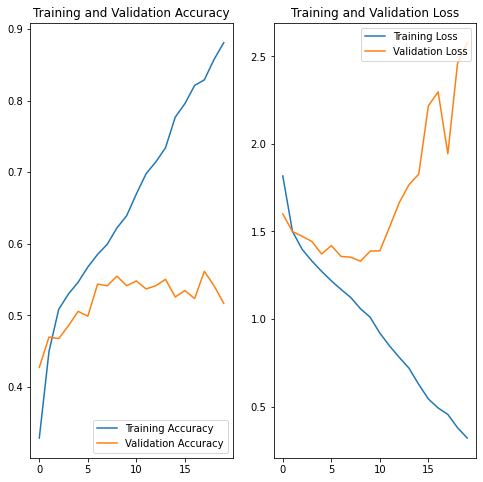

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##The above model gives an acurracy of 88% and val_accuracy of 51%
##It clearly shows evidence of **overfitting**
##Lets apply drop out and check the accuracy and val_accuracy

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [39]:
##Setting up the data again
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)
# Extract the labels from the dataset
labels = train_ds.map(lambda x, y: y)

# Convert the labels to a numpy array
labels = np.array(list(labels.as_numpy_iterator()))

# Count the occurrences of each class
class_counts = dict(zip(*np.unique(labels, return_counts=True)))
print(class_counts)

print(class_names)



Found 2239 files belonging to 9 classes.
Using 1792 files for training.
{0: 92, 1: 309, 2: 77, 3: 352, 4: 277, 5: 370, 6: 58, 7: 142, 8: 115}
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### **Findings:** 
#### - **seborrheic keratosis** class has the least number of samples
#### - **pigmented benign keratosis,melanoma, basal cell carcinoma** classes dominate the data in terms proportionate number of **samples**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [40]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [42]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
print(path_to_training_dataset)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE5FE4F6AF0>: 100%|██████████| 500/500 [00:17<00:00, 28.73 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE6041A14C0>: 100%|██████████| 500/500 [00:16<00:00, 30.94 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE604241760>: 100%|██████████| 500/500 [00:24<00:00, 20.81 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FE5FE4FE100>: 100%|██████████| 500/500 [01:18<00:00,  6.36 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE6041F6B20>: 100%|██████████| 500/500 [01:35<00:00,  5.22 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE6EB862F40>: 100%|██████████| 500/500 [00:16<00:00, 30.06 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE60470F8B0>: 100%|██████████| 500/500 [00:40<00:00, 12.31 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE60408C2B0>: 100%|██████████| 500/500 [00:16<00:00, 29.85 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE6041E00A0>: 100%|██████████| 500/500 [00:16<00:00, 30.62 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [43]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [44]:
from glob import glob

In [46]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025577.jpg_4e4e80fb-9073-4eea-8ec2-6ec700b4aa59.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029315.jpg_344e4a1d-0403-4fb4-b433-be23fc6eeb9d.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027700.jpg_90a9a8cc-f54d-4b3b-8653-48e6986f92e5.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025331.jpg_052df83c-d8c7-4436-8e22-1fbbd5c84adc.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025196.jpg_4ac89204-f8c5-4b65-b32b-cab3ed9a436c.jpg',
 'Skin cancer ISIC The Interna

In [47]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [48]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [49]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [50]:
df2['Label'].value_counts()

squamous cell carcinoma       500
nevus                         500
basal cell carcinoma          500
melanoma                      500
vascular lesion               500
actinic keratosis             500
dermatofibroma                500
seborrheic keratosis          500
pigmented benign keratosis    500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [51]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [52]:
#Setting up the train data again
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [53]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [54]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create a rescaling layer
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1/255., offset=-1)

# Apply the rescaling layer to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=9)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=9)))

#### **Todo:** Create your model (make sure to include normalization)

In [55]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(9, activation='softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [56]:
## your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [57]:
epochs = 30
## Your code goes here, use 30 epochs.

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 34s 86ms/step - loss: 3.0257 - accuracy: 0.2235 - val_loss: 7.6821 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 10s 56ms/step - loss: 1.9410 - accuracy: 0.2622 - val_loss: 5.5535 - val_accuracy: 0.1537
Epoch 3/30
169/169 [==============================] - 10s 57ms/step - loss: 1.8122 - accuracy: 0.2865 - val_loss: 3.6479 - val_accuracy: 0.2116
Epoch 4/30
169/169 [==============================] - 10s 58ms/step - loss: 1.7735 - accuracy: 0.3186 - val_loss: 2.5907 - val_accuracy: 0.2925
Epoch 5/30
169/169 [==============================] - 10s 57ms/step - loss: 1.6456 - accuracy: 0.3787 - val_loss: 2.6154 - val_accuracy: 0.3601
Epoch 6/30
169/169 [==============================] - 10s 57ms/step - loss: 1.5391 - accuracy: 0.4169 - val_loss: 2.1919 - val_accuracy: 0.4068
Epoch 7/30
169/169 [==============================] - 10s 57ms/step - loss: 1.3581 - accuracy: 0.4828 - val_loss: 2.1465 - val_accuracy:

#### **Todo:**  Visualize the model results

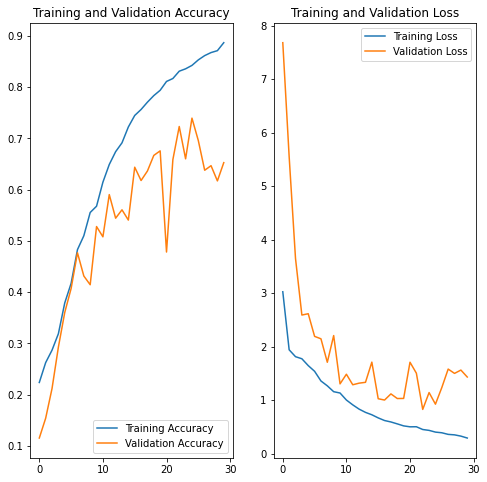

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###We can see some improvement in overfitting in comparison to the earlier executed models.
With Epoch 30:
Accuracy: 88%
Val_Accuracy: 65%

With increase in Epoch to 50 the accuracy went above 90% and val_accuracy was aroudn 80%.(as per the upgrad casestudy I am just keeping it as 30 for the epoch)

